##### top

# This ntb analyses the Face memory perception task

We have decided that we want to have the following measures for each participant:

For each task (**p**erception, **b**lank, **f**aces, **em**otions) and for each difficulty level (24, 30, 36) we want to have their accuracy and RT.


---
NOTE: I am still splitting the datasets into emotions and the rest, not optimal but safe. Another note is that all of this can be done much faster if needed by neglecting the columns right at the top. Since we still want to use it for some detailed analyses, I am not doing that.


* [Load and process the data](#Load-and-process-the-data)
* [Merge the two](#Merge-the-two)
* [Quality checks](#Quality-checks)

* [Save](#Save)

## Load and process the data

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# define paths
csv_raw_data_path = "../Data/raw_CSV"
csv_raw_pilot_data_path = "../Data/raw_CSV/piloting"

path_results = "../Analysis/Reliability"

# Importing module for functions
functions_modul =  "./functions"
sys.path.insert(0, functions_modul)
    
    
from data_processing_functions import fill_in_userID
from reliability_functions import check_double_access

In [2]:
# Speed up reading using dtypes, have not yet been tested
df = pd.read_csv(os.path.join(csv_raw_data_path, 'face_mem_perc_data.csv'),
    dtype={'count_tasks':float,
    'score_perc':float,
    'score_blank':float,
    'score_faces':float,
    'score_emotion':float,
    'count_blocks':float,
    'sender:':str,
    'sender_type':str,
    'sender_id': 'float64',
    'ended_on':str,
    'duration':'float64',
    'time_run':'float64',
    'time_render':'float64',
    'time_show':'float64',
    'time_end':'float64',
    'time_commit':'float64',
    'observation':str
})

# load also the pilot data
pilot = pd.read_csv(os.path.join(csv_raw_data_path,"piloting", 'face_mem_perc_data.csv'),
    dtype={'count_tasks':float,
    'score_perc':float,
    'score_blank':float,
    'score_faces':float,
    'score_emotion':float,
    'count_blocks':float,
    'sender:':str,
    'sender_type':str,
    'sender_id': 'float64',
    'ended_on':str,
    'duration':'float64',
    'time_run':'float64',
    'time_render':'float64',
    'time_show':'float64',
    'time_end':'float64',
    'time_commit':'float64',
    'observation':str
})

# and concatenate them
df = pd.concat([df,pilot])

# remove from mem
pilot = None

df

,count_tasks,correct_faces,score_perc,score_blank,score_faces,score_equation,score_emotion,count_blocks,sender,sender_id,...,block,distractor_img,All Raters,gender_distractor,emotion_target,emotion1,emotion2,emotion_answer,feedback,observation
0,1.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,Form-getID,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75493
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEMO Introduction - big face task,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75493
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Page-Introduction, blank",200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75493
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Screen-Instruction blank - example, s1",201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75493
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Screen-Instruction blank - example, s2",202.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Screen-blank,21710191.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dfa9
62490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Screen-answer,21710192.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dfa9
62491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isi,21710193.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dfa9
62492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sequence,2171019.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1dfa9


### Process
[top](#top)

In [3]:
# how many missed trials in experiment we want to tolerate, ~30 %
thr_miss = 50
bad_boys = pd.DataFrame(columns=["userID", "num_missed"])

## Expand the userID columns
df, fill_userID = fill_in_userID(df, output=True)
print("Pairs of observations and userIDs: \n")
[print(key, value) for key, value in fill_userID.items()]


# select only real trials
df_trials = df[df["block"].notnull()]

# how many trials there are per experiment
num_tasks = 3
num_blocks = 3
num_trials_per_task = 20
num_correct = (num_tasks+1)*num_blocks*num_trials_per_task # +1 stands for emotion which has answers for those as well

# add the missed trial to Emotions -- see other notes. They have a special label Screen-answer_face
# so look for all those screens and see if they have a missing answer
df_trials.loc[(df_trials["sender"]=="Screen-answer_face") & (df_trials["correct"].isnull()),"correct"] = "missed"

# select only completed experiments
completed_idx = df_trials[df_trials["correct"].notnull()].observation.value_counts().loc[lambda x : x==num_correct].index
# check also the not-completed
df_not_completed = df_trials[~df_trials["observation"].isin(completed_idx)]
# and then the completed
df_trials = df_trials[df_trials["observation"].isin(completed_idx)]

# Add response time 
df_trials.rename(columns={"duration":"RT"}, inplace=True)
df_not_completed.rename(columns={"duration":"RT"}, inplace=True)


# Clean -- select only relevant data and columns
# correct is either true, false or missed
df_clean = df_trials[df_trials["correct"].notnull()][["block", "correct", "response", "correctResponse",
                                                      "stim1", "stim2", "target", "RT", "userID", "observation",
                                                      "All Raters", 'gender_distractor',
                                                      'emotion_target', 'emotion1', 'emotion2']]
df_not_completed_clean = df_not_completed[df_not_completed["correct"].notnull()][["block", "correct", "response", "correctResponse",
                                                      "stim1", "stim2", "target", "RT", "userID", "observation",
                                                      "All Raters", 'gender_distractor',
                                                      'emotion_target', 'emotion1', 'emotion2']]

# account for missed trials in RT
df_clean.loc[df_clean["correct"]=="missed","RT"] = np.nan

df_clean["block"]= df_clean["block"].astype('int32')

check_double_access(df_clean)
#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)
# find if someone has two full datasets
double_visits = df_clean["userID"].value_counts()[df_clean["userID"].value_counts() != num_correct].keys()

if not double_visits.empty:
    relevant_observation = df_clean.loc[df_clean["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_clean = df_clean[~df_clean["observation"].isin(set(relevant_observation)-set(first_user_entry))]

check_double_access(df_clean)

# get number of participants
# N_participants = df_clean['userID'].unique().size
N_participants = df_clean['observation'].unique().size

print(f'\nThere are {N_participants} participants')
print(f'There has been {df_not_completed_clean["observation"].unique().size} not completed')


# alert if some participants have to many misses
tmp_missed = df_clean[df_clean.correct=="missed"].groupby("userID").correct.value_counts().reset_index(level=1, drop=True)
if tmp_missed[tmp_missed>=thr_miss].any():
    for m in tmp_missed[tmp_missed>=thr_miss].index:
        print("\nParticipant {} had {} missed trials".format(m, tmp_missed[m]))
        warnings.warn("Participant {} had {} missed trials".format(m, tmp_missed[m])) #TODO
        bad_boys = bad_boys.append(pd.DataFrame({"userID":[m], "num_missed":[tmp_missed[m]]}))
    
# drop responses from emotion and math, they have the same target and they're always
# after the actual response so one can drop them, NEEDS to be done per USER
df_clean = df_clean.loc[~df_clean.duplicated(subset=['target','userID'], keep='first')].copy()
# clean also the not completed for th SUBTASK score
df_not_completed_clean = df_not_completed_clean.loc[~df_not_completed_clean.duplicated(subset=['target','userID'], keep='first')].copy()

# add order in which stimuli were presented, CAUTION!! This skips the 7-9 block num for math
df_clean["order"]= np.tile(np.repeat(list(np.arange(1,7))+list(np.arange(10,13)),num_trials_per_task),N_participants)#np.repeat([1,2,3,4,5,6],20)

# convert answers to boolean or nan
df_clean["correct_check"] = [False if (x.lower()=='false' or x==False or x=='0.0') else True \
                             if (x.lower()=='true' or x==True or x=='1.0')\
                             else np.nan for x in df_clean['correct']]
print(df_clean.dtypes)

df_not_completed_clean["correct_check"] = [False if (x.lower()=='false' or x==False or x=='0.0') else True \
                             if (x.lower()=='true' or x==True or x=='1.0')\
                             else np.nan for x in df_not_completed_clean['correct']]

# This creates a bool series where 1 is for a matching str in either column.
# Then this series is multiplied by 1, 2, 3 to match increasing difficulty (26 is easiest -- biggest difference)
# https://stackoverflow.com/questions/47181187/finding-string-over-multiple-columns-in-pandas
df_clean["difficulty"] = df_clean[["stim1", "stim2"]].applymap(lambda x: "-24p.png" in x).any(1).astype(int)*3+\
                        df_clean[["stim1", "stim2"]].applymap(lambda x: "-30p.png" in x).any(1).astype(int)*2+\
                        df_clean[["stim1", "stim2"]].applymap(lambda x: "-36p.png" in x).any(1).astype(int)*1

df_clean["levels"] = df_clean["difficulty"].replace({1: 36, 2: 30, 3:24})

# clean up
df_trials = None

df_clean

Pairs of observations and userIDs: 

75493 s_106
91199 s_228
9cb1d s_141
1377a s_222
c58ce s_256
5577a s_167
005c2 s_142
796a2 s_127
b9acd s_163
bb96d s_117
4a751 s_122
7876c s_239
5179f s_180
30e27 s_250
fdbcd s_3
3bce1 s_172
f1254 s_216
e6aae s_82
327fd s_107
a66e3 s_25
06e68 s_209
c4137 s_103
868d0 s_217
fd19d s_120
22504 s_43
e82a7 s_48
b781d s_226
1cf2b s_221
13b8a s_213
bd72d s_184
00af9 s_33
9f420 s_139
60725 s_253
719b6 s_156
aa935 s_55
a4a6c s_212
87262 s_57
0dfb3 s_175
e3f93 s_158
f8604 s_237
3e41b s_53
c3ed8 s_116
4fe1f s_17
40cc4 s_252
555db s_83
182cd s_243
c749c s_207
e30c0 s_188
1fc2e s_193
108d9 s_199
e1852 s_34
16612 s_136
98fda s_135
89f89 s_110
b850b s_100
c4778 s_119
b928f s_102
0fbdd s_7
ed477 s_198
28a80 s_28
92765 s_36
fc5a8 s_101
e7254 s_251
20964 s_81
bcbc4 s_245
69b78 s_165
e72aa s_173
fb94f s_219
7fdba s_45
94207 s_201
08f56 s_132
c1b9a s_59
f81b8 s_160
adb81 s_138
be34a s_134
368f0 s_177
85b97 s_60
7b308 s_79
5bbbb s_65
02457 s_11
9a3db s_39
0ecc1 s_88
53022

/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


All is ok.
There are now 241 participants (observations) and 241 unique IDs.

All is ok.
There are now 241 participants (observations) and 241 unique IDs.


There are 241 participants
There has been 44 not completed

Participant s_108 had 61 missed trials

Participant s_112 had 75 missed trials

Participant s_12 had 63 missed trials

Participant s_120 had 63 missed trials

Participant s_179 had 84 missed trials

Participant s_180 had 63 missed trials

Participant s_19 had 165 missed trials

Participant s_193 had 64 missed trials

Participant s_201 had 52 missed trials

Participant s_207 had 62 missed trials

Participant s_214 had 74 missed trials

Participant s_37 had 65 missed trials

Participant s_55 had 73 missed trials
block                  int32
correct               object
response              object
correctResponse       object
stim1                 object
stim2                 object
target                object
RT                   float64
userID                object
observ

/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/2935362814.py:88: UserWarning: Participant s_108 had 61 missed trials
  warnings.warn("Participant {} had {} missed trials".format(m, tmp_missed[m])) #TODO
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/2935362814.py:88: UserWarning: Participant s_112 had 75 missed trials
  warnings.warn("Participant {} had {} missed trials".format(m, tmp_missed[m])) #TODO
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/2935362814.py:88: UserWarning: Participant s_12 had 63 missed trials
  warnings.warn("Participant {} had {} missed trials".format(m, tmp_missed[m])) #TODO
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/2935362814.py:88: UserWarning: Participant s_120 had 63 missed trials
  warnings.warn("Participant {} had {} missed trials".format(m, tmp_missed[m])) #TODO
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/2935362814.py:88: UserWarning: Participant s_179 had

,block,correct,response,correctResponse,stim1,stim2,target,RT,userID,observation,All Raters,gender_distractor,emotion_target,emotion1,emotion2,order,correct_check,difficulty,levels
40,6,True,right,right,sharp_London-F-011-03_AF01NES-24p.png,sharp_London-F-011-03_AF01NES-0p.png,sharp_London-F-011-03_AF01NES-0p.png,1186.36,s_106,75493,NaN,NaN,NaN,NaN,NaN,1,True,3,24
45,6,True,left,left,sharp_CFD-MM-308-001-N_m4018-0p.png,sharp_CFD-MM-308-001-N_m4018-36p.png,sharp_CFD-MM-308-001-N_m4018-0p.png,1842.22,s_106,75493,NaN,NaN,NaN,NaN,NaN,1,True,1,36
50,6,True,right,right,sharp_CFD-AF-215-070-N_AF01NES-24p.png,sharp_CFD-AF-215-070-N_AF01NES-0p.png,sharp_CFD-AF-215-070-N_AF01NES-0p.png,1167.82,s_106,75493,NaN,NaN,NaN,NaN,NaN,1,True,3,24
55,6,True,left,left,sharp_CFD-MM-303-002-N_m4018-0p.png,sharp_CFD-MM-303-002-N_m4018-30p.png,sharp_CFD-MM-303-002-N_m4018-0p.png,890.52,s_106,75493,NaN,NaN,NaN,NaN,NaN,1,True,2,30
60,6,True,right,right,sharp_CFD-MM-301-011-N_m4018-30p.png,sharp_CFD-MM-301-011-N_m4018-0p.png,sharp_CFD-MM-301-011-N_m4018-0p.png,1077.98,s_106,75493,NaN,NaN,NaN,NaN,NaN,1,True,2,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58366,3,False,left,right,sharp_CFD-BM-012-018-N_m4018-36p.png,sharp_CFD-BM-012-018-N_m4018-0p.png,sharp_CFD-BM-012-018-N_m4018-0p.png,1627.56,s_97,da2c2,NaN,NaN,NaN,NaN,NaN,12,False,1,36
58370,3,True,right,right,sharp_CFD-LF-218-072-N_AF01NES-36p.png,sharp_CFD-LF-218-072-N_AF01NES-0p.png,sharp_CFD-LF-218-072-N_AF01NES-0p.png,1262.30,s_97,da2c2,NaN,NaN,NaN,NaN,NaN,12,True,1,36
58374,3,True,left,left,sharp_if501_AF01NES-0p.png,sharp_if501_AF01NES-24p.png,sharp_if501_AF01NES-0p.png,1832.84,s_97,da2c2,NaN,NaN,NaN,NaN,NaN,12,True,3,24
58378,3,False,right,left,sharp_CFD-LM-220-329-N_m4018-0p.png,sharp_CFD-LM-220-329-N_m4018-24p.png,sharp_CFD-LM-220-329-N_m4018-0p.png,1452.72,s_97,da2c2,NaN,NaN,NaN,NaN,NaN,12,False,3,24


In [4]:
bad_boys["percentage_missed"] = bad_boys.num_missed/180
bad_boys

,userID,num_missed,percentage_missed
0,s_108,61,0.338889
0,s_112,75,0.416667
0,s_12,63,0.35
0,s_120,63,0.35
0,s_179,84,0.466667
0,s_180,63,0.35
0,s_19,165,0.916667
0,s_193,64,0.355556
0,s_201,52,0.288889
0,s_207,62,0.344444


In [5]:
# thr for em/eq, 30 %
thr_miss_emeq = 18 
bad_girls = pd.DataFrame(columns=["userID", "num_missed"])

# select only real trials
df_trials = df[df["block"].notnull()]

# how many trials there are per experiment
num_tasks = 3
num_blocks = 3
num_trials_per_task = 20
num_correct = (num_tasks+1)*num_blocks*num_trials_per_task # +1 stands for emotion which has answers for those as well

# add the missed trial to Emotions -- see other notes. They have a special label Screen-answer_face
# so look for all those screens and see if they have a missing answer
df_trials.loc[(df_trials["sender"]=="Screen-answer_face") & (df_trials["correct"].isnull()),"correct"] = "missed"

# select only completed experiments
completed_idx = df_trials[df_trials["correct"].notnull()].observation.value_counts().loc[lambda x : x==num_correct].index
# check also the not-completed
df_not_completed = df_trials[~df_trials["observation"].isin(completed_idx)]
# and then the completed
df_trials = df_trials[df_trials["observation"].isin(completed_idx)]

# Add response time -- old way
# df_trials.loc[:, "RT"]= df_trials[df_trials["correct"].notnull()].time_end - df_trials[df_trials["correct"].notnull()].time_show
df_trials.rename(columns={"duration":"RT"}, inplace=True)

# Clean -- select only relevant data and columns
# correct is either true, false or missed
df_emo = df_trials[df_trials["correct_faces"].notnull()][["block", "correct_faces", "response", "correctResponse", 
                                                      "stim1", "stim2", "target", "RT", "userID", "observation",
                                                      "All Raters", 'gender_distractor',
                                                      'emotion_target', 'emotion1', 'emotion2']]

# add back response since it is one row above
df_emo["response"] = df_trials[df_trials.sender=="Screen-answer-emotion"].response.values
df_emo["correctResponse"] = df_trials[df_trials.sender=="Screen-answer-emotion"].correctResponse.values

# account for missed trials in RT
df_emo.loc[df_emo["correct_faces"]=="missed","RT"] = np.nan

df_emo["block"]= df_emo["block"].astype('int32')


# alert if some participants have to many misses
tmp_missed = df_emo[df_emo.correct_faces=="missed"].groupby("userID").correct_faces.value_counts().reset_index(level=1, drop=True)
if tmp_missed[tmp_missed>=thr_miss_emeq].any():
    for m in tmp_missed[tmp_missed>=thr_miss_emeq].index:
        print("\nParticipant {} had {} missed trials in faces.".format(m, tmp_missed[m]))
        warnings.warn("Participant {} had {} missed trials in faces.".format(m, tmp_missed[m])) #TODO
        bad_girls = bad_girls.append(pd.DataFrame({"userID":[m], "num_missed":[tmp_missed[m]]}))
        
        
# add order in which stimuli were presented
df_emo["order"]= np.tile(np.repeat([range(16,19)],num_trials_per_task),N_participants)#np.repeat([1,2,3,4,5,6],20)
        
# convert answers to boolean or nan
df_emo["correct_emotion_check_flt"] = [0 if (x.lower()=='false' or x=='0.0') else 1 \
                             if (x.lower()=='true' or x=='1.0')\
                             else np.nan for x in df_emo['correct_faces'].astype(str)]
print(df_emo.dtypes)

# This creates a bool series where 1 is for a matching str in either column.
# Then this series is multiplied by 1, 2, 3 to match increasing difficulty (26 is easiest -- biggest difference)
# https://stackoverflow.com/questions/47181187/finding-string-over-multiple-columns-in-pandas
df_emo["difficulty"] = df_emo[["stim1", "stim2"]].applymap(lambda x: "-24p.png" in x).any(1).astype(int)*3+\
                        df_emo[["stim1", "stim2"]].applymap(lambda x: "-30p.png" in x).any(1).astype(int)*2+\
                        df_emo[["stim1", "stim2"]].applymap(lambda x: "-36p.png" in x).any(1).astype(int)*1

df_emo["levels"] = df_emo["difficulty"].replace({1: 36, 2: 30, 3:24})

# clean up
df_trials = None

df_emo    

/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/3175907615.py:51: UserWarning: Participant s_108 had 55 missed trials in faces.
  warnings.warn("Participant {} had {} missed trials in faces.".format(m, tmp_missed[m])) #TODO
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/3175907615.py:51: UserWarning: Participant s_179 had 23 missed trials in faces.
  warnings.warn("Participant {} had {} missed trials in faces.".format(m, tmp_missed[m])) #TODO
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_21213/3175907615.py:51: UserWarning: Participa


Participant s_108 had 55 missed trials in faces.

Participant s_179 had 23 missed trials in faces.

Participant s_19 had 30 missed trials in faces.

Participant s_207 had 59 missed trials in faces.

Participant s_214 had 44 missed trials in faces.
block                          int32
correct_faces                 object
response                      object
correctResponse               object
stim1                         object
stim2                         object
target                        object
RT                           float64
userID                        object
observation                   object
All Raters                   float64
gender_distractor             object
emotion_target                object
emotion1                      object
emotion2                      object
order                          int64
correct_emotion_check_flt    float64
dtype: object


,block,correct_faces,response,correctResponse,stim1,stim2,target,RT,userID,observation,All Raters,gender_distractor,emotion_target,emotion1,emotion2,order,correct_emotion_check_flt,difficulty,levels
380,12,True,right,right,sharp_CFD-BM-005-003-N_m4018-30p.png,sharp_CFD-BM-005-003-N_m4018-0p.png,sharp_CFD-BM-005-003-N_m4018-0p.png,503.66,s_106,75493,91.0,f,sad,angry,sad,16,1.0,2,30
386,12,True,left,left,sharp_London-F-019-03_AF01NES-0p.png,sharp_London-F-019-03_AF01NES-36p.png,sharp_London-F-019-03_AF01NES-0p.png,498.50,s_106,75493,94.0,f,happy,happy,fearful,16,1.0,1,36
392,12,True,right,right,sharp_London-M-031-03_m4018-36p.png,sharp_London-M-031-03_m4018-0p.png,sharp_London-M-031-03_m4018-0p.png,495.50,s_106,75493,97.0,m,angry,fearful,angry,16,1.0,1,36
398,12,True,right,right,sharp_m4076_m4018-0p.png,sharp_m4076_m4018-30p.png,sharp_m4076_m4018-0p.png,502.90,s_106,75493,82.0,m,fearful,neutral,fearful,16,1.0,2,30
404,12,True,left,left,sharp_bretislav_m4018-24p.png,sharp_bretislav_m4018-0p.png,sharp_bretislav_m4018-0p.png,499.20,s_106,75493,46.0,m,disgusted,disgusted,happy,16,1.0,3,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58083,11,True,left,left,sharp_bera_AF01NES-36p.png,sharp_bera_AF01NES-0p.png,sharp_bera_AF01NES-0p.png,506.18,s_97,da2c2,100.0,m,happy,happy,disgusted,18,1.0,1,36
58090,11,True,right,right,sharp_CFD-LM-202-072-N_m4018-0p.png,sharp_CFD-LM-202-072-N_m4018-36p.png,sharp_CFD-LM-202-072-N_m4018-0p.png,506.16,s_97,da2c2,99.0,m,happy,fearful,happy,18,1.0,1,36
58097,11,True,left,left,sharp_m4010_m4018-24p.png,sharp_m4010_m4018-0p.png,sharp_m4010_m4018-0p.png,495.76,s_97,da2c2,52.0,f,disgusted,disgusted,sad,18,1.0,3,24
58104,11,True,left,left,sharp_cestmir_m4018-0p.png,sharp_cestmir_m4018-24p.png,sharp_cestmir_m4018-0p.png,495.16,s_97,da2c2,42.0,f,disgusted,disgusted,happy,18,1.0,3,24


In [6]:
bad_girls["percentage_missed"] = bad_girls.num_missed/60
bad_girls

,userID,num_missed,percentage_missed
0,s_108,55,0.916667
0,s_179,23,0.383333
0,s_19,30,0.5
0,s_207,59,0.983333
0,s_214,44,0.733333


In [7]:
set(bad_boys.userID)&set(bad_girls.userID)

{'s_108', 's_179', 's_19', 's_207', 's_214'}

In [8]:
pd.merge(bad_boys,bad_girls, how="outer", on="userID")

,userID,num_missed_x,percentage_missed_x,num_missed_y,percentage_missed_y
0,s_108,61,0.338889,55,0.916667
1,s_112,75,0.416667,NaN,NaN
2,s_12,63,0.35,NaN,NaN
3,s_120,63,0.35,NaN,NaN
4,s_179,84,0.466667,23,0.383333
5,s_180,63,0.35,NaN,NaN
6,s_19,165,0.916667,30,0.5
7,s_193,64,0.355556,NaN,NaN
8,s_201,52,0.288889,NaN,NaN
9,s_207,62,0.344444,59,0.983333


## Merge the two



In [9]:
# add mapping for tasks
task_dict = {0:"perception", 1:"blank", 2:"", 3:"faces"}
df_clean["task"]=(df_clean.block-1)//3
df_clean.replace({"task": task_dict}, inplace=True)
# convert boolean answers to floats to be able to do mean
df_clean['correct_flt'] = df_clean.correct_check.astype(float)

# add cols to emo to be able to easily concat
df_emo["correct"] = df_emo["correct_faces"]
df_emo["correct_flt"] = df_emo["correct_emotion_check_flt"]
df_emo["task"] = "emotions"

# convert types for better processing
# df_clean = df_clean.convert_dtypes()
# df_emo = df_emo.convert_dtypes()

# df_clean.merge(df_emo, on="userID")
df_concat = pd.concat([df_clean, df_emo])

df_concat_clean = df_concat[["userID", "block", "correct", "correct_flt", "RT", "observation", "difficulty", "levels", "task", "response"]]

df_concat_clean

,userID,block,correct,correct_flt,RT,observation,difficulty,levels,task,response
40,s_106,6,True,1.0,1186.36,75493,3,24,blank,right
45,s_106,6,True,1.0,1842.22,75493,1,36,blank,left
50,s_106,6,True,1.0,1167.82,75493,3,24,blank,right
55,s_106,6,True,1.0,890.52,75493,2,30,blank,left
60,s_106,6,True,1.0,1077.98,75493,2,30,blank,right
...,...,...,...,...,...,...,...,...,...,...
58083,s_97,11,True,1.0,506.18,da2c2,1,36,emotions,left
58090,s_97,11,True,1.0,506.16,da2c2,1,36,emotions,right
58097,s_97,11,True,1.0,495.76,da2c2,3,24,emotions,left
58104,s_97,11,True,1.0,495.16,da2c2,3,24,emotions,left


## Quality checks

* [Check for too short RT](#Check-for-too-short-RT)
* [Check for too many times pressing one key](#Check-for-too-many-times-pressing-one-key)

[top](#top)

### Check for too short RT

In [10]:
df_concat_clean.groupby(["task"]).std()

,block,correct_flt,RT,difficulty,levels
task,,,,,
blank,0.816525,0.432678,595.188196,0.816525,4.899149
emotions,0.816525,0.339093,32.051669,0.816525,4.899149
faces,0.816525,0.473209,587.000303,0.816525,4.899149
perception,0.816525,0.353731,535.316029,0.816525,4.899149


In [11]:
# how many std from mean we want the outlier to be
num_std = -2.5 

# compute mean per participant per task, subtract mean per task, divide by std of the task, compare to thr
x = ((df_concat_clean.groupby(["userID", "task"]).mean().RT-df_concat_clean.groupby(["task"]).mean().RT)/df_concat_clean.groupby(["task"]).std().RT)< num_std

# get the corresponding ID
df_concat_clean.groupby(["userID", "task"]).mean().RT[x].reset_index()#.userID


,userID,task,RT


### Check for too many times pressing one key

### DO not run the below, skip to:
[here](#Find-it-in-the-df)

In [12]:
# flag for cell not to be run, switch if needed
simulate_cells = False

if simulate_cells:
    lengths = []
    num_steps = 15000
    max_lengths = np.zeros(num_steps, dtype=int)
    N_trials = 20

    for i in range(num_steps):
        # generate num of 0s and 1s
        num = np.random.randint(0, 2,size=N_trials)
        # convert the array into str, split it where there are zeros, get the length of the splits
        tmp_len = [len(sequence) for sequence in ''.join(str(x) for x in num).replace('0', ' ').split()]
        # append
        lengths.append(tmp_len)
        if tmp_len:
            max_lengths[i] = max(tmp_len)
        else:
            max_lengths[i] = 0

In [13]:
if simulate_cells:

    from pandas.core.common import flatten

    fig, axs = plt.subplots(1,3, figsize = (13,4))
    plt.subplots_adjust(wspace=0.4)

    sns.histplot(list(flatten(lengths)), ax=axs[0])
    sns.histplot(max_lengths, ax=axs[1], color="orange")
    sns.histplot(max_lengths, ax=axs[2], stat="probability", color="orange")

    axs[0].set_title("Distribution of lengths")
    axs[1].set_title("Distribution of max length")
    axs[1].set_ylabel('')

In [14]:
if simulate_cells:

    lengths = []
    num_steps = 15000
    max_lengths = np.zeros(num_steps, dtype=int)
    N_trials = num_trials_per_task * num_blocks * num_tasks
    # num_tasks = 3 # 
    # num_blocks = 3
    # num_trials_per_task = 20

    for i in range(num_steps):
        # generate num of 0s and 1s
        num = np.random.randint(0, 2,size=N_trials)
        # convert the array into str, split it where there are zeros, get the length of the splits
        tmp_len = [len(sequence) for sequence in ''.join(str(x) for x in num).replace('0', ' ').split()]
        # append
        lengths.append(tmp_len)
        if tmp_len:
            max_lengths[i] = max(tmp_len)
        else:
            max_lengths[i] = 0


In [15]:
if simulate_cells:
    from pandas.core.common import flatten

    fig, axs = plt.subplots(1,3, figsize = (13,4))
    plt.subplots_adjust(wspace=0.4)

    sns.histplot(list(flatten(lengths)), ax=axs[0], color='b', binwidth=1)
    sns.histplot(max_lengths, ax=axs[1], color="orange")
    sns.histplot(max_lengths, ax=axs[2], stat="probability", color="orange")

    axs[0].set_title("Distribution of lengths")
    axs[1].set_title(f"Distribution of max length, N of trials = {N_trials}")
    axs[1].set_ylabel('')

In [16]:
if simulate_cells:
    print("mean trial length", np.array(list(flatten(lengths))).mean())

In [17]:
if simulate_cells:
    fig, axs = plt.subplots(1,2)

    x,y,_ = axs[0].hist(max_lengths, bins=range(min(max_lengths), max(max_lengths) + 1, 1))

    prob = x/x.sum()

    axs[1].plot(y[1:],prob)
    axs[1].scatter(y[1:],prob)
    np.where(prob<0.1)

#### Find it in the df

#### Across (for) the participant

In [18]:
# replace() needs to be there otherwise we get a lot of '' strings in the ourput, the other replace is to have easier counting

subsequence_lengths_partic_L = []
subsequence_lengths_partic_R = []
max_lengths_partic = np.zeros(len(df_clean.userID.unique()))
avg_lengths_partic = np.zeros(len(df_clean.userID.unique()))
min_lengths_partic = np.zeros(len(df_clean.userID.unique()))
flagged_participants = []

# fig, axs = plt.subplots(len(df_clean.userID.unique()),2, figsize = (10,10*len(df_clean.userID.unique())//2))
# plt.subplots_adjust(wspace=0.4, hspace=0.3)

for i, partic in enumerate(df_clean.userID.unique()):
    tmp_list_R = None
    tmp_len_R = None
    # get a list of l's for the participant, remove nans, see more above
    tmp_list_R = ''.join(df_clean[df_clean.userID==partic].response.dropna().tolist()).replace('left',' ').replace("right", "r").split()
    # get the length of the splits
    tmp_len_R = [len(sequence) for sequence in tmp_list_R]
    # append
    subsequence_lengths_partic_R.append(tmp_len_R)

    tmp_list_L = None
    tmp_len_L = None
    # get a list of l's for the participant, remove nans, see more above
    tmp_list_L = ''.join(df_clean[df_clean.userID==partic].response.dropna().tolist()).replace('right',' ').replace("left", "l").split()
    # get the length of the splits
    tmp_len_L = [len(sequence) for sequence in tmp_list_L]
    # append
    subsequence_lengths_partic_L.append(tmp_len_L)
    
    if tmp_len_L or tmp_len_R:
        # add just the max
        max_lengths_partic[i] = max(max(tmp_len_R), max(tmp_len_L))
        min_lengths_partic[i] = min(min(tmp_len_R), min(tmp_len_L))
        avg_lengths_partic[i] = np.array(tmp_len_R+tmp_len_R).mean()
    else:
        max_lengths_partic[i] = 0
        min_lengths_partic[i] = 0                

#     if max_lengths_partic[i]>7:
#         print(f"Check participant {partic} because the longest sequence is: {max_lengths_partic[i]}")
    if max_lengths_partic[i]>10:
        print(f"Check participant {partic} because the longest sequence is: {max_lengths_partic[i]}") 
        flagged_participants.append(partic)
    
#     # plot the results
#     sns.histplot(list(flatten(lengths)), ax=axs[i,0], color='lightblue', binwidth=1, label="simulated", stat="probability")
#     sns.histplot(list(flatten(subsequence_lengths_partic_L)), ax=axs[i,0], color='darkblue', binwidth=1, label="data L", stat="probability", alpha=0.3)
#     sns.histplot(list(flatten(subsequence_lengths_partic_R)), ax=axs[i,0], color='blue', binwidth=1, label="data R", stat="probability", alpha=0.3)
    
#     sns.histplot(max_lengths, ax=axs[i,1], color="orange", label="simulated", stat="probability", binwidth=1)
#     axs[i,1].axvline(max_lengths_partic[i], label="max length for participant", c='k')

#     axs[i,0].set_title(f"Distribution of lengths, {partic}")
#     axs[i,1].set_title(f"Distribution of max length, N of trials = {N_trials}")
#     axs[i,1].set_ylabel('')       
#     axs[i,0].legend()
#     axs[i,1].legend()    

Check participant s_163 because the longest sequence is: 12.0
Check participant s_180 because the longest sequence is: 12.0
Check participant s_55 because the longest sequence is: 11.0
Check participant s_158 because the longest sequence is: 14.0
Check participant s_53 because the longest sequence is: 11.0
Check participant s_135 because the longest sequence is: 11.0
Check participant s_110 because the longest sequence is: 60.0
Check participant s_36 because the longest sequence is: 61.0
Check participant s_165 because the longest sequence is: 11.0
Check participant s_173 because the longest sequence is: 14.0
Check participant s_201 because the longest sequence is: 11.0
Check participant s_160 because the longest sequence is: 37.0
Check participant s_11 because the longest sequence is: 14.0
Check participant s_76 because the longest sequence is: 13.0
Check participant s_67 because the longest sequence is: 11.0
Check participant s_20 because the longest sequence is: 11.0
Check participa

idx of outliers:  (array([ 79,  93, 123, 189, 204, 225]),)
values:  [3.57575758 2.86111111 2.94444444 3.15384615 3.08695652 2.81081081]
in std:  [5.03026815 2.72504375 2.99385084 3.6693148  3.45354991 2.56279083]


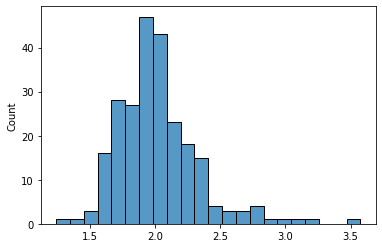

In [19]:
sns.histplot(avg_lengths_partic)
print("idx of outliers: ", np.where(avg_lengths_partic>(2.5*avg_lengths_partic.std())+avg_lengths_partic.mean()))
print("values: ", avg_lengths_partic[np.where(avg_lengths_partic>(2.5*avg_lengths_partic.std())+avg_lengths_partic.mean())])
print("in std: ", (avg_lengths_partic[np.where(avg_lengths_partic>(2.5*avg_lengths_partic.std())+avg_lengths_partic.mean())] - avg_lengths_partic.mean())/avg_lengths_partic.std())

idx of outliers:  (array([53, 60, 72]),)
values:  [60. 61. 37.]
in std:  [9.12983701 9.30857712 5.01881455]


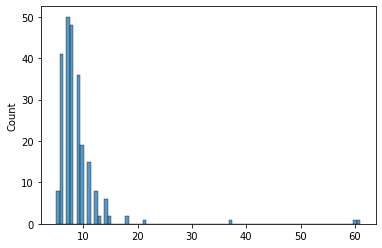

In [20]:
sns.histplot(max_lengths_partic)
print("idx of outliers: ", np.where(max_lengths_partic>(2.5*max_lengths_partic.std())+max_lengths_partic.mean()))
print("values: ", max_lengths_partic[np.where(max_lengths_partic>(2.5*max_lengths_partic.std())+max_lengths_partic.mean())])
print("in std: ", (max_lengths_partic[np.where(max_lengths_partic>(2.5*max_lengths_partic.std())+max_lengths_partic.mean())] - max_lengths_partic.mean())/max_lengths_partic.std())


In [21]:
# merge the two measures into one df -- look at max and avg length, find the outliers (2.5 std), merge dfs 
num_std = 2.5 

df_flagged_length_task = pd.merge(
pd.DataFrame({
    "userID": df_clean.userID.unique()[np.where(avg_lengths_partic>(num_std*avg_lengths_partic.std())+avg_lengths_partic.mean())],
    "avg_length_task_std": (avg_lengths_partic[np.where(avg_lengths_partic>(num_std*avg_lengths_partic.std())+avg_lengths_partic.mean())] - avg_lengths_partic.mean())/avg_lengths_partic.std()
}),
pd.DataFrame({
    "userID": df_clean.userID.unique()[np.where(max_lengths_partic>(num_std*max_lengths_partic.std())+max_lengths_partic.mean())],
    "max_length_task_std": (max_lengths_partic[np.where(max_lengths_partic>(num_std*max_lengths_partic.std())+max_lengths_partic.mean())] - max_lengths_partic.mean())/max_lengths_partic.std()
}),
    on = "userID", how="outer"
)

df_flagged_length_task

,userID,avg_length_task_std,max_length_task_std
0,s_11,5.030268,NaN
1,s_76,2.725044,NaN
2,s_225,2.993851,NaN
3,s_91,3.669315,NaN
4,s_112,3.453550,NaN
5,s_94,2.562791,NaN
6,s_110,NaN,9.129837
7,s_36,NaN,9.308577
8,s_160,NaN,5.018815


In [22]:
# add accuracy
df_flagged_length_task = pd.merge( df_flagged_length_task,
(df_clean.loc[df_clean.userID.isin(df_flagged_length_task.userID)].groupby("userID").mean()).loc[:,["RT","correct_flt"]].reset_index(), 
on="userID", how="outer")

# rename cols
# df_flagged_length_task

# add std acc, rename with suffixes. BE CAREFUL with this

df_flagged_length_task = pd.merge( df_flagged_length_task,
((df_clean[df_clean.userID.isin(df_flagged_length_task.userID)].groupby("userID").mean()-df_concat_clean.mean())/df_concat_clean.std()).loc[:,["RT","correct_flt"]].reset_index(),
on="userID", how="outer", suffixes=["_absolute", "_std"])


df_flagged_length_task

,userID,avg_length_task_std,max_length_task_std,RT_absolute,correct_flt_absolute,RT_std,correct_flt_std
0,s_11,5.030268,NaN,2498.502825,0.604520,1.586956,-0.434849
1,s_76,2.725044,NaN,1550.067977,0.732955,0.249444,-0.122963
2,s_225,2.993851,NaN,1178.890130,0.598870,-0.274003,-0.448569
3,s_91,3.669315,NaN,1545.156537,0.720670,0.242517,-0.152794
4,s_112,3.453550,NaN,1846.521390,0.628571,0.667511,-0.376443
5,s_94,2.562791,NaN,1697.864749,0.777143,0.457871,-0.015658
6,s_110,NaN,9.129837,968.165536,0.731844,-0.571173,-0.125661
7,s_36,NaN,9.308577,1216.083443,0.602273,-0.221552,-0.440306
8,s_160,NaN,5.018815,1445.288953,0.584795,0.101681,-0.482748


#### Look at accuracy of those subjects

In [23]:
# Look at group avg
df_clean.mean()

block               6.000000
RT               1666.633249
All Raters         81.516667
order               6.000000
correct_check       0.755320
difficulty          2.000000
levels             30.000000
correct_flt         0.755320
dtype: float64

In [24]:
# df_clean.loc[df_clean.userID.isin(flagged_participants), ["userID", "RT", "order", "correct_flt"]].groupby("userID").mean()

In [25]:
# check how far is the mean
((df_clean[df_clean.userID.isin(flagged_participants)].groupby("userID").mean()-df_concat_clean.mean())/df_concat_clean.std()).loc[:,["RT","correct_flt"]]


,RT,correct_flt
userID,,
s_10,0.138582,-0.124106
s_11,1.586956,-0.434849
s_110,-0.571173,-0.125661
s_112,0.667511,-0.376443
s_125,-0.124878,-0.434530
s_135,0.123089,0.064267
s_145,0.912576,-0.050702
s_150,0.352035,-0.220625
s_154,1.043023,-0.334814


In [26]:
# print(df_clean.loc[df_clean.userID.isin(['s_110', 's_36', 's_160']),
#             ["userID","RT","correct_flt"]])
          
          
(df_clean.loc[df_clean.userID.isin(['s_110', 's_36', 's_160'])].groupby("userID").mean()).loc[:,["RT","correct_flt"]].reset_index()



,userID,RT,correct_flt
0,s_110,968.165536,0.731844
1,s_160,1445.288953,0.584795
2,s_36,1216.083443,0.602273


In [27]:
# how many std from mean we want the outlier to be
num_std = -2.5 

# compute mean per participant per task, subtract mean per task, divide by std of the task, compare to thr
x = ((df_clean[df_clean.userID.isin(flagged_participants)].groupby("userID").mean()-df_concat_clean.mean())/df_concat_clean.std()).loc[:,["RT","correct_flt"]]< num_std

# get the corresponding ID
((df_clean[df_clean.userID.isin(flagged_participants)].groupby("userID").mean()-df_concat_clean.mean())/df_concat_clean.std()).loc[x["correct_flt"]]


,All Raters,RT,block,correct_flt,difficulty,levels,order
userID,,,,,,,


#### Across the participants per block

In [28]:
flagged_participants_subtasks={'blank':[], 'faces':[], 'perception':[], 'emotions':[]}
length_participants_subtasks_data={'blank':[], 'faces':[], 'perception':[], 'emotions':[]}

# replace() needs to be there otherwise we get a lot of '' strings in the ourput, the other replace is to have easier counting

for task in df_concat_clean.task.unique():

    subsequence_lengths_partic_L = []
    subsequence_lengths_partic_R = []
    max_lengths_partic = np.zeros(len(df_concat_clean.userID.unique()))
    avg_lengths_partic = np.zeros(len(df_concat_clean.userID.unique()))
    min_lengths_partic = np.zeros(len(df_concat_clean.userID.unique()))

#     fig, axs = plt.subplots(len(df_clean.userID.unique()),2, figsize = (13,10))
#     plt.subplots_adjust(wspace=0.4, hspace=0.3)

    for i, partic in enumerate(df_concat_clean.userID.unique()):
        tmp_list_R = None
        tmp_len_R = None
        # get a list of l's for the participant, remove nans, see more above
        tmp_list_R = ''.join(df_concat_clean[(df_concat_clean.userID==partic)&(df_concat_clean.task==task)].response.dropna().tolist()).replace('left',' ').replace("right", "r").split()
        # get the length of the splits
        tmp_len_R = [len(sequence) for sequence in tmp_list_R]
        # append
        subsequence_lengths_partic_R.append(tmp_len_R)

        tmp_list_L = None
        tmp_len_L = None
        # get a list of l's for the participant, remove nans, see more above
        tmp_list_L = ''.join(df_concat_clean[(df_concat_clean.userID==partic)&(df_concat_clean.task==task)].response.dropna().tolist()).replace('right',' ').replace("left", "l").split()
        # get the length of the splits
        tmp_len_L = [len(sequence) for sequence in tmp_list_L]
        # append
        subsequence_lengths_partic_L.append(tmp_len_L)

        if tmp_len_L or tmp_len_R:
            if not tmp_len_L:
                tmp_len_L = [0]
            if not tmp_len_R:
                tmp_len_R = [0]                
            # add just the max
            max_lengths_partic[i] = max(max(tmp_len_R), max(tmp_len_L))
            min_lengths_partic[i] = min(min(tmp_len_R), min(tmp_len_L))
            avg_lengths_partic[i] = np.array(tmp_len_R+tmp_len_R).mean()
        else:
            max_lengths_partic[i] = 0
            min_lengths_partic[i] = 0                
            
#         if max_lengths_partic[i]>5:
#             print(f"Check participant {partic} because the longest sequence is: {max_lengths_partic[i]} in task: {task}")
        if max_lengths_partic[i]>10:
            print(f"Check participant {partic} because the longest sequence is: {max_lengths_partic[i]} in task: {task}")
            flagged_participants_subtasks[task].append(partic)
            
#         # plot the results
#         sns.histplot(list(flatten(lengths)), ax=axs[i,0], color='lightblue', binwidth=1, label="simulated", stat="probability")
#         sns.histplot(list(flatten(subsequence_lengths_partic_L)), ax=axs[i,0], color='darkblue', binwidth=1, label="data L", stat="probability", alpha=0.3)
#         sns.histplot(list(flatten(subsequence_lengths_partic_R)), ax=axs[i,0], color='blue', binwidth=1, label="data R", stat="probability", alpha=0.3)

#         sns.histplot(max_lengths, ax=axs[i,1], color="orange", label="simulated", stat="probability", binwidth=1)
#         axs[i,1].axvline(max_lengths_partic[i], label="max length for participant", c='k')

#         axs[i,0].set_title(f"Distribution of lengths, {partic}")
#         axs[i,1].set_title(f"Distribution of max length, N of trials = {N_trials}")
#         axs[i,1].set_ylabel('')       
#         axs[i,0].legend()
#         axs[i,1].legend()    


    # append to full score
    length_participants_subtasks_data[task].append([avg_lengths_partic, max_lengths_partic])

Check participant s_163 because the longest sequence is: 12.0 in task: blank
Check participant s_180 because the longest sequence is: 12.0 in task: blank
Check participant s_55 because the longest sequence is: 11.0 in task: blank
Check participant s_135 because the longest sequence is: 11.0 in task: blank
Check participant s_36 because the longest sequence is: 13.0 in task: blank
Check participant s_165 because the longest sequence is: 11.0 in task: blank
Check participant s_201 because the longest sequence is: 11.0 in task: blank
Check participant s_11 because the longest sequence is: 11.0 in task: blank
Check participant s_76 because the longest sequence is: 13.0 in task: blank
Check participant s_67 because the longest sequence is: 11.0 in task: blank
Check participant s_20 because the longest sequence is: 11.0 in task: blank
Check participant s_154 because the longest sequence is: 11.0 in task: blank
Check participant s_99 because the longest sequence is: 21.0 in task: blank
Check 


Task:  blank
avg:
idx of outliers:  (array([ 69,  79, 111, 213]),)
values:  [3.88888889 3.88888889 3.8        3.7       ]
in std:  [3.64900367 3.64900367 3.46555729 3.25918011]

max:
idx of outliers:  (array([ 60,  93, 213, 217]),)
values:  [13. 13. 21. 18.]
in std:  [2.81211403 2.81211403 6.30326397 4.99408275]

Task:  faces
avg:
idx of outliers:  (array([ 34, 123, 189, 225]),)
values:  [7.         5.33333333 3.66666667 3.81818182]
in std:  [7.76384567 5.24332716 2.72280865 2.95194669]

max:
idx of outliers:  (array([53, 60]),)
values:  [60. 58.]
in std:  [9.9308686  9.55597208]

Task:  perception
avg:
idx of outliers:  (array([ 11,  66,  79, 122, 204, 221]),)
values:  [3.44444444 3.66666667 4.09090909 3.27272727 4.625      4.55555556]
in std:  [2.89887408 3.35368158 4.22195046 2.54743192 5.31503894 5.1729116 ]

max:
idx of outliers:  (array([ 38,  66,  72,  79, 122]),)
values:  [14. 14. 37. 14. 15.]
in std:  [ 2.67439019  2.67439019 10.75734811  2.67439019  3.02582314]

Task:  emoti

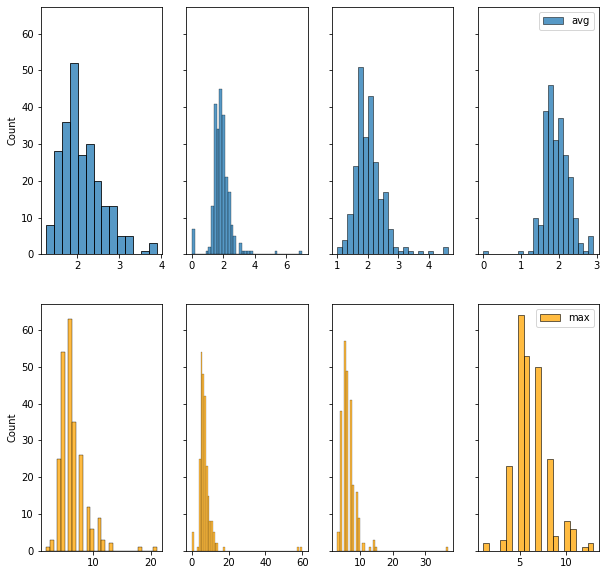

In [29]:
num_std = 2.5

fig, axs = plt.subplots(2,4, figsize=(10,10), sharey=True)

for j, tsk in enumerate(length_participants_subtasks_data.keys()):
    sns.histplot(length_participants_subtasks_data[tsk][0][0], ax=axs[0,j], label="avg")
    sns.histplot(length_participants_subtasks_data[tsk][0][1], ax=axs[1,j], color='orange', label="max")
    
    print("\nTask: ", tsk)
    print("avg:")
    print("idx of outliers: ", np.where(length_participants_subtasks_data[tsk][0][0]>(num_std*length_participants_subtasks_data[tsk][0][0].std())+length_participants_subtasks_data[tsk][0][0].mean()))
    print("values: ", length_participants_subtasks_data[tsk][0][0][np.where(length_participants_subtasks_data[tsk][0][0]>(num_std*length_participants_subtasks_data[tsk][0][0].std())+length_participants_subtasks_data[tsk][0][0].mean())])
    print("in std: ", (length_participants_subtasks_data[tsk][0][0][np.where(length_participants_subtasks_data[tsk][0][0]>(num_std*length_participants_subtasks_data[tsk][0][0].std())+length_participants_subtasks_data[tsk][0][0].mean())] - length_participants_subtasks_data[tsk][0][0].mean())/length_participants_subtasks_data[tsk][0][0].std())
    print("\nmax:")
    print("idx of outliers: ", np.where(length_participants_subtasks_data[tsk][0][1]>(num_std*length_participants_subtasks_data[tsk][0][1].std())+length_participants_subtasks_data[tsk][0][1].mean()))
    print("values: ", length_participants_subtasks_data[tsk][0][1][np.where(length_participants_subtasks_data[tsk][0][1]>(num_std*length_participants_subtasks_data[tsk][0][1].std())+length_participants_subtasks_data[tsk][0][1].mean())])
    print("in std: ", (length_participants_subtasks_data[tsk][0][1][np.where(length_participants_subtasks_data[tsk][0][1]>(num_std*length_participants_subtasks_data[tsk][0][1].std())+length_participants_subtasks_data[tsk][0][1].mean())] - length_participants_subtasks_data[tsk][0][1].mean())/length_participants_subtasks_data[tsk][0][1].std())


axs[0,-1].legend()
axs[1,-1].legend()

In [30]:
# both sides
tsk = "faces"
(length_participants_subtasks_data[tsk][0][0][np.where((length_participants_subtasks_data[tsk][0][0]>(num_std*length_participants_subtasks_data[tsk][0][0].std()
                                                        +length_participants_subtasks_data[tsk][0][0].mean()))
        | (length_participants_subtasks_data[tsk][0][0]<(-num_std*length_participants_subtasks_data[tsk][0][0].std()
                                                         +length_participants_subtasks_data[tsk][0][0].mean()))
        )] - length_participants_subtasks_data[tsk][0][0].mean())/length_participants_subtasks_data[tsk][0][0].std()



array([-2.82233208,  7.76384567, -2.82233208, -2.82233208, -2.82233208,
        5.24332716, -2.82233208, -2.82233208,  2.72280865, -2.82233208,
        2.95194669])

In [31]:
np.where((length_participants_subtasks_data[tsk][0][0]>(num_std*length_participants_subtasks_data[tsk][0][0].std()
                                                        +length_participants_subtasks_data[tsk][0][0].mean()))
        | (length_participants_subtasks_data[tsk][0][0]<(-num_std*length_participants_subtasks_data[tsk][0][0].std()
                                                         +length_participants_subtasks_data[tsk][0][0].mean()))
        )

(array([ 23,  34,  48,  53,  60, 123, 172, 186, 189, 204, 225]),)

In [32]:
# merge the two measures into one df -- look at max and avg length, find the outliers (2.5 std), merge dfs 
num_std = 2.5 
flagged_length_subtask_list = []

for i, tsk in enumerate(length_participants_subtasks_data.keys()):

    flag_idx_avg = None
    flag_idx_max = None
    # get idx if it is 2.5 std any direction
    flag_idx_avg = np.where((length_participants_subtasks_data[tsk][0][0]>(num_std*length_participants_subtasks_data[tsk][0][0].std()
                                                            +length_participants_subtasks_data[tsk][0][0].mean()))
            | (length_participants_subtasks_data[tsk][0][0]<(-num_std*length_participants_subtasks_data[tsk][0][0].std()
                                                             +length_participants_subtasks_data[tsk][0][0].mean()))
            )

    flag_idx_max = np.where((length_participants_subtasks_data[tsk][0][1]>(num_std*length_participants_subtasks_data[tsk][0][1].std()
                                                            +length_participants_subtasks_data[tsk][0][1].mean()))
            | (length_participants_subtasks_data[tsk][0][1]<(-num_std*length_participants_subtasks_data[tsk][0][1].std()
                                                             +length_participants_subtasks_data[tsk][0][1].mean()))
            )

    flagged_length_subtask_list.append(pd.merge(
    pd.DataFrame({
        "userID": df_concat_clean.userID.unique()[np.where(avg_lengths_partic>(num_std*avg_lengths_partic.std())+avg_lengths_partic.mean())],
        "avg_length_subtask_std": (avg_lengths_partic[np.where(avg_lengths_partic>(num_std*avg_lengths_partic.std())+avg_lengths_partic.mean())] - avg_lengths_partic.mean())/avg_lengths_partic.std(),
        "subtask_avg": tsk
    }),
    pd.DataFrame({
        "userID": df_concat_clean.userID.unique()[np.where(max_lengths_partic>(num_std*max_lengths_partic.std())+max_lengths_partic.mean())],
        "max_length_subtask_std": (max_lengths_partic[np.where(max_lengths_partic>(num_std*max_lengths_partic.std())+max_lengths_partic.mean())] - max_lengths_partic.mean())/max_lengths_partic.std(),
        "subtask_max": tsk
    }),
        on = "userID", how="outer"
    ))

    # add acc, rename with suffixes. BE CAREFUL with this -- order of df (and hence suffixes) can change
    flagged_length_subtask_list[i] = pd.merge( flagged_length_subtask_list[i],
    df_concat_clean[(df_concat_clean.userID.isin(flagged_length_subtask_list[i].userID)) & (df_concat_clean.task==tsk)].groupby("userID").mean().loc[:,["RT","correct_flt"]].reset_index(),
    on="userID", how="outer", suffixes=["_absolute", "_std"])
    
    # and standardised score
    flagged_length_subtask_list[i] = pd.merge( flagged_length_subtask_list[i],
    ((df_concat_clean[(df_concat_clean.userID.isin(flagged_length_subtask_list[i].userID)) & (df_concat_clean.task==tsk)].groupby("userID").mean()
    -df_concat_clean[df_concat_clean.task==tsk].mean())/df_concat_clean[df_concat_clean.task==tsk].mean().std()).loc[:,["RT","correct_flt"]],
    on="userID", how="outer", suffixes=["_absolute", "_std"])    
    

# df_flagged_length_subtask = pd.merge(flagged_length_subtask_list[0], flagged_length_subtask_list[1], on = ["userID","subtask_avg", "subtask_max"], how="outer")
# df_flagged_length_subtask = pd.merge(df_flagged_length_subtask, flagged_length_subtask_list[2], on = ["userID","subtask_avg", "subtask_max"], how="outer")

# merge on all keys

df_flagged_length_subtask = pd.merge(flagged_length_subtask_list[0], flagged_length_subtask_list[1], on = list(flagged_length_subtask_list[0].keys()), how="outer")
df_flagged_length_subtask = pd.merge(df_flagged_length_subtask, flagged_length_subtask_list[2], on = list(flagged_length_subtask_list[0].keys()), how="outer")

df_flagged_length_subtask

,userID,avg_length_subtask_std,subtask_avg,max_length_subtask_std,subtask_max,RT_absolute,correct_flt_absolute,RT_std,correct_flt_std
0,s_252,2.874578,blank,NaN,NaN,1633.269793,0.793103,-0.077424,0.000056
1,s_88,2.901579,blank,3.118995,blank,1701.156356,0.830508,0.012809,0.000106
2,s_131,2.631561,blank,NaN,NaN,1745.838813,0.525424,0.072200,-0.000299
3,s_125,2.676564,blank,NaN,NaN,905.882776,0.500000,-1.044250,-0.000333
4,s_63,2.714644,blank,NaN,NaN,1887.805136,0.559322,0.260899,-0.000254
5,s_122,NaN,NaN,2.574695,blank,1766.023431,0.844828,0.099029,0.000125
6,s_212,NaN,NaN,2.574695,blank,1425.491621,0.672414,-0.353598,-0.000104
7,s_34,NaN,NaN,2.574695,blank,1305.901717,0.716667,-0.512554,-0.000045
8,s_36,NaN,NaN,3.663295,blank,1063.624467,0.533333,-0.834584,-0.000289
9,s_24,NaN,NaN,2.574695,blank,2299.231228,0.596491,0.807757,-0.000205


#### Look at accuracy of those subjects

In [33]:
flagged_participants_subtasks

{'blank': ['s_163',
  's_180',
  's_55',
  's_135',
  's_36',
  's_165',
  's_201',
  's_11',
  's_76',
  's_67',
  's_20',
  's_154',
  's_99',
  's_202',
  's_54',
  's_71'],
 'faces': ['s_158',
  's_53',
  's_135',
  's_110',
  's_36',
  's_76',
  's_26',
  's_225',
  's_224',
  's_125',
  's_183',
  's_238',
  's_150',
  's_31',
  's_190',
  's_10',
  's_18',
  's_218',
  's_41',
  's_145'],
 'perception': ['s_158',
  's_173',
  's_160',
  's_11',
  's_233',
  's_27',
  's_112',
  's_218'],
 'emotions': ['s_122',
  's_212',
  's_34',
  's_36',
  's_88',
  's_24',
  's_50',
  's_128',
  's_41']}

In [34]:
# Look at group avg
df_concat_clean.groupby(["task"]).mean()

,block,correct_flt,RT,difficulty,levels
task,,,,,
blank,5,0.750605,1691.519378,2,30
emotions,11,0.867456,502.664224,2,30
faces,11,0.661522,1702.360729,2,30
perception,2,0.853388,1605.811615,2,30


#### Do it for all tasks

In [35]:
# how many std from mean we want the outlier to be
num_std = -2.5 

for tsk in list(flagged_participants_subtasks.keys()):
#     ((df_clean[(df_clean.userID.isin(flagged_participants_subtasks[tsk])) & (df_clean.task==tsk)].groupby("userID").mean()
#   -df_clean[df_clean.task==tsk].mean())/df_clean[df_clean.task==tsk].mean().std()).loc[:,["RT","correct_flt"]]
    x = ((df_concat_clean[(df_concat_clean.userID.isin(flagged_participants_subtasks[tsk])) & (df_concat_clean.task==tsk)].groupby("userID").mean()
  -df_concat_clean[df_concat_clean.task==tsk].mean())/df_concat_clean[df_concat_clean.task==tsk].mean().std()).loc[:,["RT","correct_flt"]]
    y = x< num_std

    if y.correct_flt.any():
        print(tsk)
        print(x[y])
    else:
        print(f"{tsk} has no outliers")

blank has no outliers
faces has no outliers
perception has no outliers
emotions has no outliers


In [36]:
(df_concat_clean[(df_concat_clean.userID.isin(['s_110', 's_36'])) & (df_concat_clean.task=='faces')].groupby("userID").mean()).loc[:,["RT","correct_flt"]].reset_index()



,userID,RT,correct_flt
0,s_110,685.545850,0.483333
1,s_36,1178.137362,0.500000


In [37]:
(df_concat_clean[(df_concat_clean.userID.isin(['s_160'])) & (df_concat_clean.task=='perception')].groupby("userID").mean()).loc[:,["RT","correct_flt"]].reset_index()



,userID,RT,correct_flt
0,s_160,1245.366586,0.517241


## List of dropped participants

1. Look at signal detection theory and deal with missed trials (count them in)
2. Check where they miss trials (which trial)
3. Make a screen with "you're too slow" if they're timed out in the real experiment

## Who to exclude

a) exclude all who have more than 30 % missed trials (since there would not be enough data to compare them)

b) exclude all who have significantly missed a lot of data in a specific subtask (as a)) even if their performance is good or if they passed a)


#### Missed trials in general

In [38]:
exclude_miss = list(set(bad_boys.userID)|set(bad_girls.userID))
exclude_miss

['s_55',
 's_12',
 's_179',
 's_37',
 's_108',
 's_19',
 's_201',
 's_180',
 's_193',
 's_112',
 's_207',
 's_214',
 's_120']

#### flags in general

In [39]:
df_flagged_length_task

,userID,avg_length_task_std,max_length_task_std,RT_absolute,correct_flt_absolute,RT_std,correct_flt_std
0,s_11,5.030268,NaN,2498.502825,0.604520,1.586956,-0.434849
1,s_76,2.725044,NaN,1550.067977,0.732955,0.249444,-0.122963
2,s_225,2.993851,NaN,1178.890130,0.598870,-0.274003,-0.448569
3,s_91,3.669315,NaN,1545.156537,0.720670,0.242517,-0.152794
4,s_112,3.453550,NaN,1846.521390,0.628571,0.667511,-0.376443
5,s_94,2.562791,NaN,1697.864749,0.777143,0.457871,-0.015658
6,s_110,NaN,9.129837,968.165536,0.731844,-0.571173,-0.125661
7,s_36,NaN,9.308577,1216.083443,0.602273,-0.221552,-0.440306
8,s_160,NaN,5.018815,1445.288953,0.584795,0.101681,-0.482748


In [40]:
df_flagged_length_task.loc[~df_flagged_length_task.max_length_task_std.isnull(), "userID"].values

array(['s_110', 's_36', 's_160'], dtype=object)

In [41]:
exclude_task = ['s_11', 's_110', 's_36', 's_160']


#### flags per subtask

In [42]:
# do not look at the one already excluded anyway
df_flagged_length_subtask[~df_flagged_length_subtask.userID.isin(exclude_miss+exclude_task)]

,userID,avg_length_subtask_std,subtask_avg,max_length_subtask_std,subtask_max,RT_absolute,correct_flt_absolute,RT_std,correct_flt_std
0,s_252,2.874578,blank,NaN,NaN,1633.269793,0.793103,-0.077424,0.000056
1,s_88,2.901579,blank,3.118995,blank,1701.156356,0.830508,0.012809,0.000106
2,s_131,2.631561,blank,NaN,NaN,1745.838813,0.525424,0.072200,-0.000299
3,s_125,2.676564,blank,NaN,NaN,905.882776,0.500000,-1.044250,-0.000333
4,s_63,2.714644,blank,NaN,NaN,1887.805136,0.559322,0.260899,-0.000254
5,s_122,NaN,NaN,2.574695,blank,1766.023431,0.844828,0.099029,0.000125
6,s_212,NaN,NaN,2.574695,blank,1425.491621,0.672414,-0.353598,-0.000104
7,s_34,NaN,NaN,2.574695,blank,1305.901717,0.716667,-0.512554,-0.000045
9,s_24,NaN,NaN,2.574695,blank,2299.231228,0.596491,0.807757,-0.000205
10,s_50,NaN,NaN,2.574695,blank,1305.271793,0.724138,-0.513392,-0.000035


#### Combine the excluded participants

In [43]:
excluded_ptc = list(set(exclude_miss+exclude_task))

print(f"Excluding {len(excluded_ptc)} participants.")

pd.DataFrame({"exclude":excluded_ptc}).to_csv(os.path.join(path_results, 'exclude_fmp_ptc.csv'), index=False)

Excluding 17 participants.


In [44]:
set(bad_boys.userID)&set(excluded_ptc)#&set(bad_girls)

{'s_108',
 's_112',
 's_12',
 's_120',
 's_179',
 's_180',
 's_19',
 's_193',
 's_201',
 's_207',
 's_214',
 's_37',
 's_55'}

In [45]:
df_bad_boys = pd.merge(bad_boys, (df_concat_clean[df_concat_clean.userID.isin(bad_boys.userID)].groupby("userID").mean()).loc[:,["RT","correct_flt"]].reset_index(), how='outer', on='userID')
df_bad_boys = pd.merge(df_bad_boys, 
                         ((df_concat_clean[df_concat_clean.userID.isin(bad_boys.userID)].groupby("userID").mean()-df_concat_clean.mean())/df_concat_clean.std()).loc[:,["RT","correct_flt"]].reset_index(),
                        how='outer', on='userID', suffixes=["_absolute", "_std"])

df_bad_girls = pd.merge(bad_girls, (df_concat_clean[df_concat_clean.userID.isin(bad_girls.userID)].groupby("userID").mean()).loc[:,["RT","correct_flt"]].reset_index(), how='outer', on='userID')
df_bad_girls = pd.merge(df_bad_girls, 
                         ((df_concat_clean[df_concat_clean.userID.isin(df_bad_girls.userID)].groupby("userID").mean()-df_concat_clean.mean())/df_concat_clean.std()).loc[:,["RT","correct_flt"]].reset_index(),
                        how='outer', on='userID', suffixes=["_absolute", "_std"])

In [46]:
df_clean[df_clean.userID=="s_110"].groupby("task").correct.value_counts()

task        correct
blank       True       51
            False       9
faces       False      31
            True       29
perception  True       51
            False       8
            missed      1
Name: correct, dtype: int64

In [47]:
df_all_flagged_problems = pd.merge(df_bad_boys, df_bad_girls, on=list(df_bad_boys.keys()), how="outer", suffixes=["_main","_em"])
df_all_flagged_problems = pd.merge(df_all_flagged_problems, df_flagged_length_task, on=["userID", "RT_absolute", "correct_flt_absolute", "RT_std", "correct_flt_std"] , how="outer")
df_all_flagged_problems = pd.merge(df_all_flagged_problems, df_flagged_length_subtask, on=["userID", "RT_absolute", "correct_flt_absolute", "RT_std", "correct_flt_std"], how="outer")

# get a count of missing values -- the smaller the worse - more flags. But not 100 % because of subtask
df_all_flagged_problems["count_nan"] = df_all_flagged_problems.isnull().sum(axis=1)

df_all_flagged_problems

,userID,num_missed,percentage_missed,RT_absolute,correct_flt_absolute,RT_std,correct_flt_std,avg_length_task_std,max_length_task_std,avg_length_subtask_std,subtask_avg,max_length_subtask_std,subtask_max,count_nan
0,s_108,61.0,0.338889,1373.778905,0.642458,0.000835,-0.342721,NaN,NaN,NaN,NaN,NaN,NaN,6
1,s_108,55.0,0.916667,1373.778905,0.642458,0.000835,-0.342721,NaN,NaN,NaN,NaN,NaN,NaN,6
2,s_112,75.0,0.416667,1358.385067,0.721212,-0.020873,-0.151478,NaN,NaN,NaN,NaN,NaN,NaN,6
3,s_12,63.0,0.350000,1435.823362,0.711864,0.088332,-0.174178,NaN,NaN,NaN,NaN,NaN,NaN,6
4,s_120,63.0,0.350000,1440.439768,0.949153,0.094843,0.402044,NaN,NaN,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,s_36,NaN,NaN,1411.745707,0.775862,-0.271668,-0.000109,NaN,NaN,NaN,NaN,3.663295,perception,6
62,s_24,NaN,NaN,2021.395172,0.672414,0.581765,-0.000253,NaN,NaN,NaN,NaN,2.574695,perception,6
63,s_50,NaN,NaN,1092.596133,0.816667,-0.718437,-0.000051,NaN,NaN,NaN,NaN,2.574695,perception,6
64,s_128,NaN,NaN,1707.445085,0.711864,0.142274,-0.000198,NaN,NaN,NaN,NaN,3.663295,perception,6


In [48]:
df_all_flagged_problems.userID.value_counts()

s_36     4
s_24     3
s_34     3
s_212    3
s_88     3
s_63     3
s_125    3
s_128    3
s_252    3
s_50     3
s_131    3
s_122    3
s_41     3
s_112    2
s_108    2
s_179    2
s_214    2
s_207    2
s_19     2
s_37     1
s_180    1
s_94     1
s_120    1
s_193    1
s_11     1
s_201    1
s_160    1
s_110    1
s_12     1
s_76     1
s_55     1
s_91     1
s_225    1
Name: userID, dtype: int64

In [49]:
df_all_flagged_problems.sort_values('count_nan')

,userID,num_missed,percentage_missed,RT_absolute,correct_flt_absolute,RT_std,correct_flt_std,avg_length_task_std,max_length_task_std,avg_length_subtask_std,subtask_avg,max_length_subtask_std,subtask_max,count_nan
28,s_88,NaN,NaN,1701.156356,0.830508,0.012809,0.000106,NaN,NaN,2.901579,blank,3.118995,blank,4
41,s_88,NaN,NaN,1871.929458,0.627119,0.224141,-0.000045,NaN,NaN,2.901579,faces,3.118995,faces,4
54,s_88,NaN,NaN,1965.070855,0.890909,0.502918,0.000053,NaN,NaN,2.901579,perception,3.118995,perception,4
0,s_108,61.0,0.338889,1373.778905,0.642458,0.000835,-0.342721,NaN,NaN,NaN,NaN,NaN,NaN,6
35,s_36,NaN,NaN,1063.624467,0.533333,-0.834584,-0.000289,NaN,NaN,NaN,NaN,3.663295,blank,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,s_112,NaN,NaN,1846.521390,0.628571,0.667511,-0.376443,3.453550,NaN,NaN,NaN,NaN,NaN,7
23,s_94,NaN,NaN,1697.864749,0.777143,0.457871,-0.015658,2.562791,NaN,NaN,NaN,NaN,NaN,7
24,s_110,NaN,NaN,968.165536,0.731844,-0.571173,-0.125661,NaN,9.129837,NaN,NaN,NaN,NaN,7
25,s_36,NaN,NaN,1216.083443,0.602273,-0.221552,-0.440306,NaN,9.308577,NaN,NaN,NaN,NaN,7


### Save

In [52]:
# make a copy
df_clean_all = df_clean.copy()
# remove them from later analysis?
df_clean = df_clean[~df_clean.userID.isin(excluded_ptc)].copy()

df_clean.to_csv(os.path.join(csv_raw_data_path, 'complex_FMP_pilot.csv'))

In [51]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Tue Jun 06 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

pandas    : 1.2.4
numpy     : 1.19.1
seaborn   : 0.11.1
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
matplotlib: 3.6.2



[top](#top)